# ENA Factor Analysis — Short Thesis (> $1B MC Universe)

This notebook builds a Fama–French style factor model over large-cap crypto assets and uses it to analyze **Ethena (ENA)** for a short thesis in the Franklin Templeton × Midwest Blockchain Conference research competition.

**High-level steps:**

1. Use the **Artemis SDK** to pull fundamental & price data for all assets.
2. Construct a **weekly panel** (2022–present) with:
   - Market cap (`mc`)
   - Market cap to fees ratio (`mc_fees_ratio`)
   - Price and weekly returns
3. Define the **> $1B circulating market cap universe** and exclude stablecoins/derivatives.
4. Build time-series factors:
   - **Market factor**: MC-weighted large-cap index (top 20 by MC)
   - **SMB**: Small minus Big (within > $1B)
   - **MOM**: Momentum (top vs bottom 30% by 12-week return)
   - **VALUE**: Value (low vs high MC/fees ratio)
5. Compute **ENA weekly returns** and run regressions:
   - ENA raw/log returns vs Market + SMB + MOM + VALUE.
6. Summarize and visualize ENA’s factor exposures as evidence for a short thesis.


In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from artemis import Artemis

WEEKS_PER_YEAR = 52

def annualize_from_weekly_raw(alpha_week, se_week):
    """
    For raw (simple) weekly returns:
    - Approximate annualized alpha as 52 * alpha_week
    - Maintain t-statistics (scale alpha and SE by same factor).
    """
    alpha_ann = WEEKS_PER_YEAR * alpha_week
    se_ann = WEEKS_PER_YEAR * se_week
    t = alpha_week / se_week if se_week != 0 else np.nan
    return alpha_ann, se_ann, t

def annualize_from_weekly_log(alpha_week_log, se_week_log):
    """
    For log weekly returns:
    - Annual log alpha = 52 * alpha_week_log
    - Convert to simple percentage alpha via exp(alpha_ann_log) - 1
    - t-stat invariant under scaling.
    """
    alpha_ann_log = WEEKS_PER_YEAR * alpha_week_log
    alpha_ann_simple = np.exp(alpha_ann_log) - 1
    se_ann_log = WEEKS_PER_YEAR * se_week_log
    t = alpha_week_log / se_week_log if se_week_log != 0 else np.nan
    return alpha_ann_log, alpha_ann_simple, se_ann_log, t


plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# -----------------------------------
# Artemis API key
# -----------------------------------
# Recommended: set as environment variable before running:
#   export ARTEMIS_API_KEY="your_key_here"
#
# For convenience in this notebook, we allow direct assignment as fallback.

API_KEY = "vl9b8JVhQHK5ceAOspCeYe66timNx4g0nNoyHyCEgMo"  # <- don't commit this to Git

client = Artemis(api_key=API_KEY)

# Analysis window
START_DATE = "2022-01-01"   # factor & universe start
END_DATE   = "2025-11-21"           # None = latest available; or e.g. "2025-11-20"

MC_THRESHOLD = 1_000_000_000  # > $1B universe
MIN_CROSS_SECTION = 20        # minimum number of >$1B assets to build style factors
TOP_N_MARKET = 20          # top N by MC for MARKET
MOM_LOOKBACK_WEEKS = 12       # 12-week momentum with 1-week skip


## 1. Retrieve asset metrics from Artemis

We:

1. Get the full asset symbol list from Artemis.
2. Pull **price**, **market cap (`mc`)**, and **market cap to fees ratio (`mc_fees_ratio`)**.
3. Build a long panel and pivot to have metrics as columns:  
   `index = (date, asset)` → columns = `mc`, `mc_fees_ratio`, `price`.


In [10]:
import time

# 1. List all asset symbols
all_assets = client.asset.list_asset_symbols()
symbols = [asset["symbol"] for asset in all_assets["assets"]]

if END_DATE is None:
    from datetime import datetime
    END_DATE = datetime.utcnow().strftime("%Y-%m-%d")

metrics = "price,mc,mc_fees_ratio"

# smaller batch size to be kinder to the API
symbol_batch_size = 50

full_data_dict = {}
failed_batches = []

for i in range(0, len(symbols), symbol_batch_size):
    batch = symbols[i:i + symbol_batch_size]
    print(f"Fetching metrics for batch {i//symbol_batch_size + 1} / {len(symbols)//symbol_batch_size + 1} "
          f"({len(batch)} symbols)...")

    success = False
    for attempt in range(3):  # up to 3 retries
        try:
            metrics_for_asset = client.fetch_metrics(
                metric_names=metrics,
                symbols=batch,
                start_date=START_DATE,
                end_date=END_DATE,
            )
            full_data_dict.update(metrics_for_asset.data.symbols)
            success = True
            # short sleep between successful calls to avoid hammering the API
            time.sleep(0.5)
            break
        except Exception as e:
            print(f"  Attempt {attempt+1} failed for this batch: {e}")
            # longer sleep before retrying this batch
            time.sleep(2)

    if not success:
        print("  Failed all retries for this batch. Skipping these symbols.")
        failed_batches.extend(batch)

print(f"\nTotal symbols fetched successfully: {len(full_data_dict)}")
print(f"Total symbols failed (skipped): {len(failed_batches)}")

# ---- Flatten into a DataFrame exactly as before ----
records = []

for asset, metric_dict in full_data_dict.items():
    for metric, values in metric_dict.items():
        for item in values:
            if isinstance(item, dict):
                records.append({
                    "date": item["date"],
                    "asset": asset,
                    "metric": metric,
                    "value": item["val"],
                })

raw_df = pd.DataFrame(records)

# Pivot: (date, asset) as index, metrics as columns
pivoted_df = raw_df.pivot(
    index=["date", "asset"],
    columns="metric",
    values="value",
).reset_index()

pivoted_df.columns.name = None
pivoted_df["date"] = pd.to_datetime(pivoted_df["date"])
pivoted_df = pivoted_df.set_index("date").sort_index()

pivoted_df.head()


Fetching metrics for batch 1 / 10 (50 symbols)...
Fetching metrics for batch 2 / 10 (50 symbols)...
Fetching metrics for batch 3 / 10 (50 symbols)...
Fetching metrics for batch 4 / 10 (50 symbols)...
Fetching metrics for batch 5 / 10 (50 symbols)...
Fetching metrics for batch 6 / 10 (50 symbols)...
Fetching metrics for batch 7 / 10 (50 symbols)...
Fetching metrics for batch 8 / 10 (50 symbols)...
Fetching metrics for batch 9 / 10 (50 symbols)...
Fetching metrics for batch 10 / 10 (28 symbols)...

Total symbols fetched successfully: 478
Total symbols failed (skipped): 0


,asset,mc,mc_fees_ratio,price
date,,,,
2022-01-01,ATH,NaN,NaN,NaN
2022-01-01,M,NaN,NaN,NaN
2022-01-01,aave,3.563670e+09,14.181055,266.532032
2022-01-01,aca,NaN,NaN,NaN
2022-01-01,acx,NaN,NaN,NaN


## 2. Weekly resampling and feature engineering

We:

- Resample to **weekly frequency** per asset (last observation of the week).
- Compute:
  - Weekly % price change (`price_weekly_pct_change`)
  - Prior-week market cap (`mc_t_minus_1`)
  - Prior-week value proxy (`mc_fees_ratio_t_minus_1`)
  - 12-week momentum (`price_12wk_pct_change`), with a 1-week skip to mitigate short-term mean reversion.
- Drop stablecoins from the universe (symbols containing 'usd').


In [11]:
# Weekly resample by asset
weekly_df = pivoted_df.groupby("asset").resample("W").agg({
    "mc": "last",
    "mc_fees_ratio": "last",
    "price": "last",
}).reset_index()

weekly_df = weekly_df.sort_values(["date", "asset"])

# Weekly returns
weekly_df["price_weekly_pct_change"] = (
    weekly_df.groupby("asset")["price"].pct_change()
)

# Lagged metrics (t-1)
weekly_df["mc_t_minus_1"] = (
    weekly_df.groupby("asset")["mc"].shift(1)
)
weekly_df["mc_fees_ratio_t_minus_1"] = (
    weekly_df.groupby("asset")["mc_fees_ratio"].shift(1)
)

# 12-week momentum with 1-week skip:
# momentum at time t = price(t-1)/price(t-13) - 1
weekly_df["price_12wk_pct_change"] = (
    weekly_df.groupby("asset")["price"]
    .transform(lambda x: x.shift(1) / x.shift(1 + MOM_LOOKBACK_WEEKS) - 1)
)

# Remove stablecoins (crude filter by 'usd' in symbol)
weekly_df = weekly_df[~weekly_df["asset"].str.contains("usd", case=False, na=False)]

# Keep 2022+ only (safety, in case Artemis gave earlier data)
weekly_df = weekly_df[weekly_df["date"] >= pd.to_datetime(START_DATE)]

# Drop assets that have no mc AND no price across the entire window
valid_assets = weekly_df.groupby("asset")[["mc", "price"]].apply(
    lambda g: g.notna().any().any()
)
weekly_df = weekly_df[weekly_df["asset"].isin(valid_assets[valid_assets].index)]

# Drop leading rows before first valid mc/price for each asset
def drop_leading_all_nan(group):
    mask_valid = group[["mc", "price"]].notna().any(axis=1)
    if not mask_valid.any():
        return pd.DataFrame(columns=group.columns)
    first_valid_idx = mask_valid.idxmax()
    return group.loc[first_valid_idx:]

weekly_df = (
    weekly_df
    .sort_values(["asset", "date"])
    .groupby("asset", group_keys=False)
    .apply(drop_leading_all_nan)
    .reset_index(drop=True)
)

weekly_df.head()


weekly_df.head()


/var/folders/w8/x1rpwfh944lbn_nnxkcqkpdm0000gn/T/ipykernel_78971/455604950.py:12: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_df.groupby("asset")["price"].pct_change()
/var/folders/w8/x1rpwfh944lbn_nnxkcqkpdm0000gn/T/ipykernel_78971/455604950.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(drop_leading_all_nan)


,asset,date,mc,mc_fees_ratio,price,price_weekly_pct_change,mc_t_minus_1,mc_fees_ratio_t_minus_1,price_12wk_pct_change
0,ATH,2024-06-16,2.476514e+08,NaN,0.065564,NaN,NaN,NaN,NaN
1,ATH,2024-06-23,2.592730e+08,NaN,0.068642,0.046946,2.476514e+08,NaN,NaN
2,ATH,2024-06-30,2.621057e+08,NaN,0.069333,0.010063,2.592730e+08,NaN,NaN
3,ATH,2024-07-07,2.491405e+08,NaN,0.066000,-0.048070,2.621057e+08,NaN,NaN
4,ATH,2024-07-14,2.810513e+08,NaN,0.074392,0.127146,2.491405e+08,NaN,NaN


## 3. Construct Fama–French style factors

For each week:

- Define the **large-cap universe** as assets with `mc_t_minus_1 >= $1B`.
- Require at least **20 assets** in this universe to build style factors.
- Compute:

1. **Market factor** (`market`):  
   - MC-weighted portfolio of the **top 20 assets by `mc`** (within > $1B universe).
2. **SMB** (`smb`):  
   - Split >$1B universe at median `mc_t_minus_1`.
   - `SMB = return_small - return_big`, where each side is MC-weighted.
3. **MOM** (`mom`):  
   - Within >$1B universe, take top 30% vs bottom 30% by `price_12wk_pct_change`.
   - MC-weighted long–short.
4. **VALUE** (`value`):  
   - Within >$1B universe, take lowest 30% vs highest 30% by `mc_fees_ratio_t_minus_1`.
   - MC-weighted long–short.

If fewer than 20 assets qualify in a given week, we skip factor construction for that week.


In [12]:
factor_returns = []

for date, group in weekly_df.groupby("date"):
    # Use only assets with valid lagged MC and weekly return
    group = group.copy()
    group_1b = group[group["mc_t_minus_1"] >= MC_THRESHOLD].dropna(
        subset=["mc_t_minus_1", "price_weekly_pct_change"]
    )

    if len(group_1b) < MIN_CROSS_SECTION:
        # Not enough large caps to build stable factors
        continue

    result = {"date": date}

    # Helper for MC-weighted average return
    def mc_weighted_return(df, mc_col="mc_t_minus_1", ret_col="price_weekly_pct_change"):
        w = df[mc_col]
        r = df[ret_col]
        if w.sum() == 0:
            return np.nan
        return (w * r).sum() / w.sum()

    # market: top N by current MC (not lagged)
    bench_group = group_1b.dropna(subset=["mc", "price_weekly_pct_change"])
    if not bench_group.empty:
        topN = bench_group.nlargest(TOP_N_MARKET, "mc")
        result["market"] = mc_weighted_return(topN, mc_col="mc")

    # SMB: Small minus Big (by mc_t_minus_1)
    smb_group = group_1b.dropna(subset=["mc_t_minus_1", "price_weekly_pct_change"])
    if not smb_group.empty:
        mc_median = smb_group["mc_t_minus_1"].median()
        small = smb_group[smb_group["mc_t_minus_1"] <= mc_median]
        big   = smb_group[smb_group["mc_t_minus_1"] > mc_median]
        if len(small) > 0 and len(big) > 0:
            result["smb"] = mc_weighted_return(small) - mc_weighted_return(big)

    # MOM: Top vs bottom 30% by 12-week momentum
    mom_group = group_1b.dropna(
        subset=["mc_t_minus_1", "price_12wk_pct_change", "price_weekly_pct_change"]
    )
    if len(mom_group) >= MIN_CROSS_SECTION:
        k = int(len(mom_group) * 0.3)
        if k >= 1:
            top_mom = mom_group.nlargest(k, "price_12wk_pct_change")
            bottom_mom = mom_group.nsmallest(k, "price_12wk_pct_change")
            result["mom"] = mc_weighted_return(top_mom) - mc_weighted_return(bottom_mom)

    # VALUE: Low vs high mc_fees_ratio (value vs expensive)
    value_group = group_1b.dropna(
        subset=["mc_t_minus_1", "price_weekly_pct_change", "mc_fees_ratio_t_minus_1"]
    )
    if len(value_group) >= MIN_CROSS_SECTION:
        k = int(len(value_group) * 0.3)
        if k >= 1:
            low_mult  = value_group.nsmallest(k, "mc_fees_ratio_t_minus_1")
            high_mult = value_group.nlargest(k, "mc_fees_ratio_t_minus_1")
            result["value"] = mc_weighted_return(low_mult) - mc_weighted_return(high_mult)

    # Keep only if we computed at least the market
    if "market" in result:
        factor_returns.append(result)

factor_returns_df = pd.DataFrame(factor_returns).sort_values("date").reset_index(drop=True)
factor_returns_df.head()


,date,market,smb,value,mom
0,2022-01-09,-0.133028,-0.000673,-0.060644,NaN
1,2022-01-16,0.053235,0.009399,-0.008442,NaN
2,2022-01-23,-0.189374,-0.092163,-0.028402,NaN
3,2022-01-30,0.014802,0.016594,-0.014207,NaN
4,2022-02-06,0.137603,0.041196,0.048439,NaN


## 4. ENA weekly returns

We extract ENA's weekly price series from the same `weekly_df` and compute raw and log returns.

> **Note:** Artemis symbols are usually lowercase (e.g., `ena`), but double-check in your data with `weekly_df['asset'].unique()`.


In [13]:
# Inspect a few asset names to confirm ENA symbol
weekly_df["asset"].drop_duplicates().sort_values()

# Assume symbol is 'ena' (change here if needed)
ENA_SYMBOL = "ena"

ena_df = weekly_df[weekly_df["asset"] == ENA_SYMBOL].copy()
ena_df = ena_df.sort_values("date")

# Raw and log returns, aligned with weekly factor frequency
ena_df["ENA_price"] = ena_df["price"].astype(float)
ena_df["ENA_raw_ret"] = ena_df["ENA_price"].pct_change()
ena_df["ENA_log_ret"] = np.log(ena_df["ENA_price"]).diff()

ena_df[["date", "ENA_price", "ENA_raw_ret", "ENA_log_ret"]].tail(5)


,date,ENA_price,ENA_raw_ret,ENA_log_ret
14349,2025-10-26,0.509746,0.057080,0.055510
14350,2025-11-02,0.373956,-0.266387,-0.309774
14351,2025-11-09,0.326602,-0.126630,-0.135396
14352,2025-11-16,0.275191,-0.157411,-0.171276
14353,2025-11-23,0.236969,-0.138895,-0.149539


## 5. Factor regressions: ENA vs Market, SMB, MOM, VALUE

We merge ENA’s weekly returns with our factor return series on the date index, then run OLS regressions:

1. **ENA raw returns** on `[market, smb, mom, value]`
2. **ENA log returns** on `[market, smb, mom, value]`

Formally:


$r^{ENA}_t = \alpha + \beta_{MKT} \cdot r^{MKT}_t + \beta_{SMB} \cdot SMB_t + \beta_{MOM} \cdot MOM_t + \beta_{VALUE} \cdot VALUE_t + \varepsilon_t$





In [19]:
# Merge on date
fact = factor_returns_df.set_index("date")
ena = ena_df.set_index("date")

merged = ena[["ENA_raw_ret", "ENA_log_ret"]].join(
    fact[["market", "smb", "mom", "value"]],
    how="inner",
)

# Drop missing values
reg_df = merged.dropna()
reg_df.head()

# Design matrix (factors + intercept)
X = sm.add_constant(reg_df[["market", "smb", "mom", "value"]])

# 1) Raw returns regression
y_raw = reg_df["ENA_raw_ret"]
model_raw = sm.OLS(y_raw, X).fit()

# 2) Log returns regression
y_log = reg_df["ENA_log_ret"]
model_log = sm.OLS(y_log, X).fit()

print("=== ENA RAW RETURNS ~ market + SMB + MOM + VALUE ===")
print(model_raw.summary())

print("\n=== ENA LOG RETURNS ~ market + SMB + MOM + VALUE ===")
print(model_log.summary())


=== ENA RAW RETURNS ~ market + SMB + MOM + VALUE ===
                            OLS Regression Results                            
Dep. Variable:            ENA_raw_ret   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     31.19
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           1.20e-15
Time:                        00:32:32   Log-Likelihood:                 56.259
No. Observations:                  85   AIC:                            -102.5
Df Residuals:                      80   BIC:                            -90.31
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

## 6. Full Four-Factor summary for ENA

We extract alpha, betas, and R² for both specifications, which will feed directly into the written short thesis.


In [20]:
def compact_summary(m):
    params = m.params
    alpha = params["const"]
    betas = params.drop("const")
    r2 = m.rsquared
    return alpha, betas, r2

alpha_raw, betas_raw, r2_raw = compact_summary(model_raw)
alpha_log, betas_log, r2_log = compact_summary(model_log)

print("=== Raw returns ===")
print(f"alpha: {alpha_raw:.4e}")
print(betas_raw)
print(f"R^2: {r2_raw:.3f}")

print("\n=== Log returns ===")
print(f"alpha: {alpha_log:.4e}")
print(betas_log)
print(f"R^2: {r2_log:.3f}")


=== Raw returns ===
alpha: 6.6356e-04
market    1.673306
smb       0.961562
mom      -0.065559
value     0.267629
dtype: float64
R^2: 0.609

=== Log returns ===
alpha: -1.8538e-02
market    1.654645
smb       0.922837
mom      -0.039223
value     0.319267
dtype: float64
R^2: 0.620


## 7. Visual diagnostics

We plot:

1. ENA vs Market factor portfolio weekly returns over time.
2. Scatter plots of ENA returns vs market, color-coded by time (early vs late).


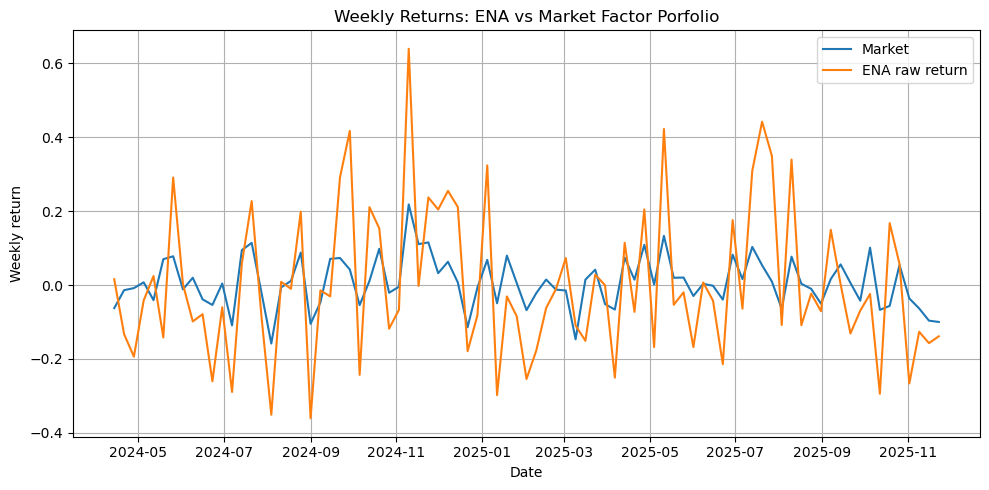

In [21]:
fig, ax = plt.subplots()

ax.plot(reg_df.index, reg_df["market"], label="Market")
ax.plot(reg_df.index, reg_df["ENA_raw_ret"], label="ENA raw return")

ax.set_title("Weekly Returns: ENA vs Market Factor Porfolio")
ax.set_xlabel("Date")
ax.set_ylabel("Weekly return")
ax.legend()
plt.tight_layout()
plt.show()


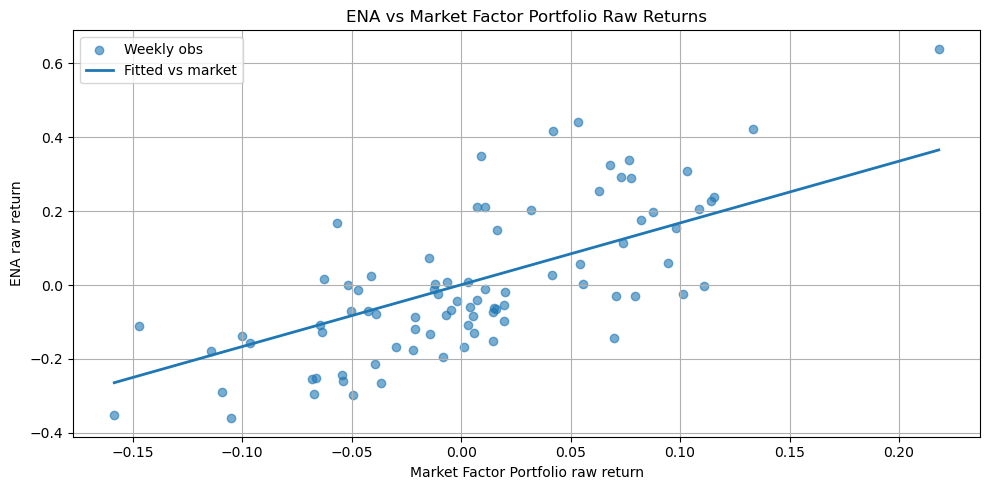

In [22]:
fig, ax = plt.subplots()

ax.scatter(reg_df["market"], reg_df["ENA_raw_ret"], alpha=0.6, label="Weekly obs")

# Fit line using raw regression coefficients
b0 = model_raw.params["const"]
b1 = model_raw.params["market"]
x_vals = np.linspace(reg_df["market"].min(), reg_df["market"].max(), 100)
y_hat = b0 + b1 * x_vals
ax.plot(x_vals, y_hat, linewidth=2, label="Fitted vs market")

ax.set_title("ENA vs Market Factor Portfolio Raw Returns")
ax.set_xlabel("Market Factor Portfolio raw return")
ax.set_ylabel("ENA raw return")
ax.legend()
plt.tight_layout()
plt.show()


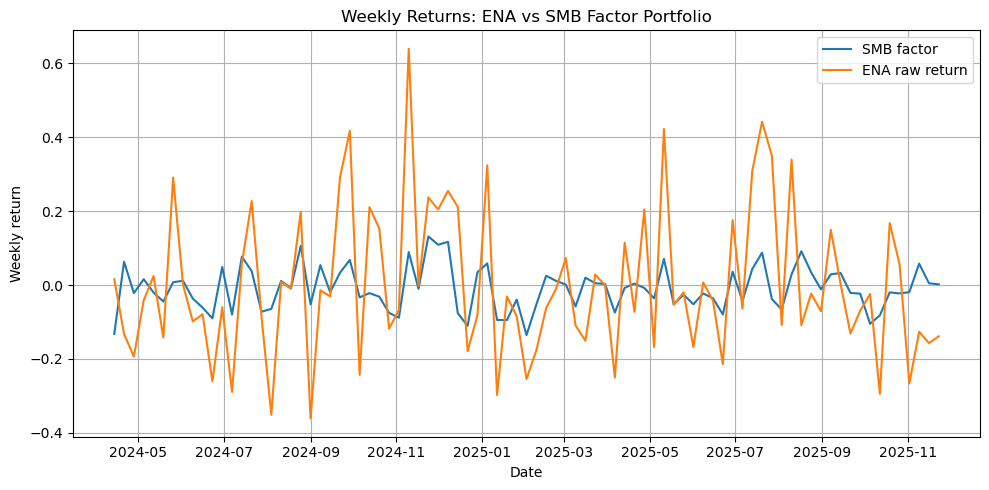

In [36]:
fig, ax = plt.subplots()

ax.plot(reg_df.index, reg_df["smb"], label="SMB factor")
ax.plot(reg_df.index, reg_df["ENA_raw_ret"], label="ENA raw return")

ax.set_title("Weekly Returns: ENA vs SMB Factor Portfolio")
ax.set_xlabel("Date")
ax.set_ylabel("Weekly return")
ax.legend()
plt.tight_layout()
plt.show()


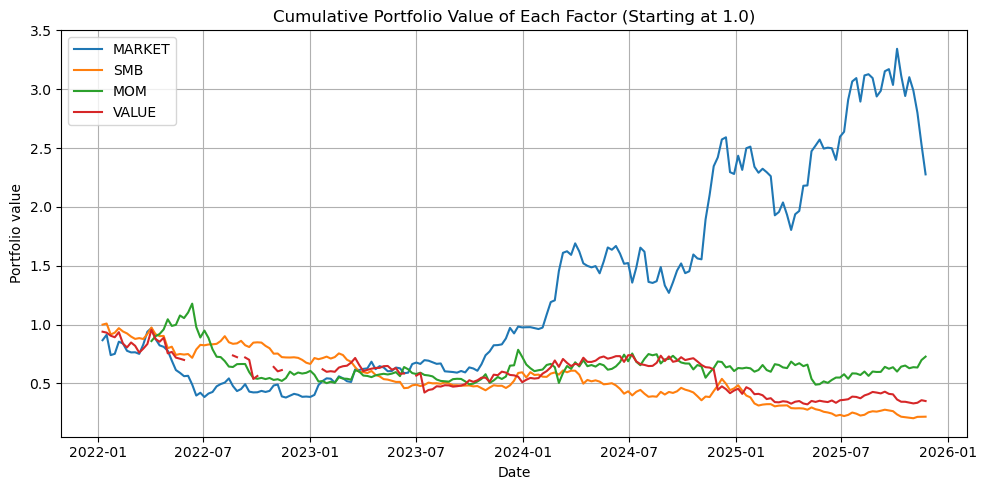

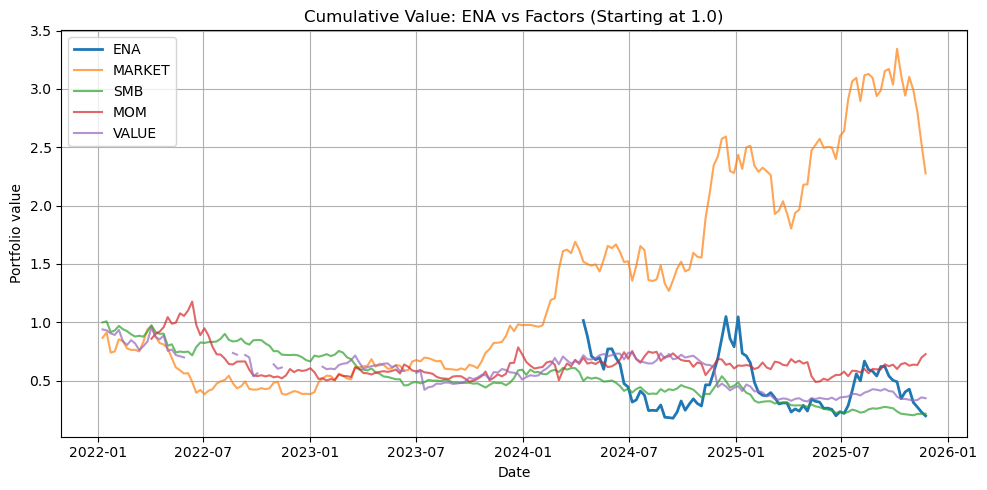

In [23]:
# Assume factor_returns_df has columns: ["date", "market", "smb", "mom", "value"]

factor_df = factor_returns_df.set_index("date").sort_index()

# Start all factor portfolios at 1.0
initial_value = 1.0
factor_values = pd.DataFrame(index=factor_df.index)

for col in ["market", "smb", "mom", "value"]:
    # Cumulative product of (1 + weekly return)
    factor_values[col] = initial_value * (1 + factor_df[col]).cumprod()

factor_values.head()


plt.figure(figsize=(10, 5))
for col in ["market", "smb", "mom", "value"]:
    plt.plot(factor_values.index, factor_values[col], label=col.upper())

plt.title("Cumulative Portfolio Value of Each Factor (Starting at 1.0)")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.tight_layout()
plt.show()

# Assuming ena_weekly (or ena_df) has ENA_raw_ret aligned to same weekly dates
ena_value = initial_value * (1 + reg_df["ENA_raw_ret"]).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(ena_value.index, ena_value, label="ENA", linewidth=2)

for col in ["market", "smb", "mom", "value"]:
    plt.plot(factor_values.index, factor_values[col], label=col.upper(), alpha=0.7)

plt.title("Cumulative Value: ENA vs Factors (Starting at 1.0)")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.tight_layout()
plt.show()



## 7. Univariate and Bivariate Factor Regressions

For diagnostics, we also run separate regressions of ENA on each factor individually:

- ENA ~ market  
- ENA ~ SMB  
- ENA ~ MOM  
- ENA ~ VALUE  

These are not our primary estimates (they ignore factor correlations), but they help ensure the multi-factor results are sensible and suggest that the Market and SMB factors are the most statistically significant and thus explanatory for ENA

In [30]:
# reg_df already has: ENA_raw_ret, ENA_log_ret, market, smb, mom, value

def run_univariate(dep, factor_name):
    X = sm.add_constant(reg_df[[factor_name]])
    y = reg_df[dep]
    model = sm.OLS(y, X).fit()
    print(f"\n=== {dep} ~ {factor_name} ===")
    print(model.summary())
    return model

uni_models_raw = {}
uni_models_log = {}

for fac in ["market", "smb", "mom", "value"]:
    uni_models_raw[fac] = run_univariate("ENA_raw_ret", fac)
    uni_models_log[fac] = run_univariate("ENA_log_ret", fac)



=== ENA_raw_ret ~ market ===
                            OLS Regression Results                            
Dep. Variable:            ENA_raw_ret   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     96.52
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           1.47e-15
Time:                        01:01:34   Log-Likelihood:                 49.105
No. Observations:                  85   AIC:                            -94.21
Df Residuals:                      83   BIC:                            -89.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0134 

In [31]:
# Two-factor regressions: ENA ~ market + smb

# Design matrix with intercept, market, smb
X_2 = sm.add_constant(reg_df[["market", "smb"]])

# Raw returns
y_raw = reg_df["ENA_raw_ret"]
model_2_raw = sm.OLS(y_raw, X_2).fit()

# Log returns
y_log = reg_df["ENA_log_ret"]
model_2_log = sm.OLS(y_log, X_2).fit()

print("=== ENA_RAW_RET ~ market + smb ===")
print(model_2_raw.summary())

print("\n=== ENA_LOG_RET ~ market + smb ===")
print(model_2_log.summary())


=== ENA_RAW_RET ~ market + smb ===
                            OLS Regression Results                            
Dep. Variable:            ENA_raw_ret   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     62.43
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           3.34e-17
Time:                        01:01:43   Log-Likelihood:                 55.644
No. Observations:                  85   AIC:                            -105.3
Df Residuals:                      82   BIC:                            -97.96
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.

In [29]:
def compact_summary_two(m):
    alpha = m.params["const"]
    beta_mkt = m.params["market"]
    beta_smb = m.params["smb"]
    r2 = m.rsquared
    return alpha, beta_mkt, beta_smb, r2

alpha2_raw, betaM2_raw, betaS2_raw, r2_2_raw = compact_summary_two(model_2_raw)
alpha2_log, betaM2_log, betaS2_log, r2_2_log = compact_summary_two(model_2_log)

print("Two-factor (RAW): alpha={:.4e}, beta_M={:.3f}, beta_SMB={:.3f}, R²={:.3f}"
      .format(alpha2_raw, betaM2_raw, betaS2_raw, r2_2_raw))
print("Two-factor (LOG): alpha={:.4e}, beta_M={:.3f}, beta_SMB={:.3f}, R²={:.3f}"
      .format(alpha2_log, betaM2_log, betaS2_log, r2_2_log))

Two-factor (RAW): alpha=-9.0401e-04, beta_M=1.722, beta_SMB=1.010, R²=0.604
Two-factor (LOG): alpha=-2.0208e-02, beta_M=1.697, beta_SMB=0.978, R²=0.612


In [34]:
# ---- 4-factor model (market + smb + mom + value) ----

# Raw spec
alpha_w_raw_4 = model_raw.params["const"]
se_w_raw_4 = model_raw.bse["const"]
alpha_ann_raw_4, se_ann_raw_4, t_ann_raw_4 = annualize_from_weekly_raw(alpha_w_raw_4, se_w_raw_4)

# Log spec
alpha_w_log_4 = model_log.params["const"]
se_w_log_4 = model_log.bse["const"]
alpha_ann_log_4, alpha_ann_simple_4, se_ann_log_4, t_ann_log_4 = annualize_from_weekly_log(
    alpha_w_log_4, se_w_log_4
)

# ---- 2-factor model (market + smb) ----

# Raw spec
alpha_w_raw_2 = model_2_raw.params["const"]
se_w_raw_2 = model_2_raw.bse["const"]
alpha_ann_raw_2, se_ann_raw_2, t_ann_raw_2 = annualize_from_weekly_raw(alpha_w_raw_2, se_w_raw_2)

# Log spec
alpha_w_log_2 = model_2_log.params["const"]
se_w_log_2 = model_2_log.bse["const"]
alpha_ann_log_2, alpha_ann_simple_2, se_ann_log_2, t_ann_log_2 = annualize_from_weekly_log(
    alpha_w_log_2, se_w_log_2
)

# Put in a small summary table
annual_alpha_summary = pd.DataFrame({
    "model": ["4-factor (raw)", "4-factor (log)", "2-factor (raw)", "2-factor (log)"],
    "alpha_week": [alpha_w_raw_4, alpha_w_log_4, alpha_w_raw_2, alpha_w_log_2],
    "alpha_ann_raw_approx": [alpha_ann_raw_4, np.nan, alpha_ann_raw_2, np.nan],
    "alpha_ann_log": [np.nan, alpha_ann_log_4, np.nan, alpha_ann_log_2],
    "alpha_ann_simple": [np.nan, alpha_ann_simple_4, np.nan, alpha_ann_simple_2],
    "t_stat": [t_ann_raw_4, t_ann_log_4, t_ann_raw_2, t_ann_log_2],
})

annual_alpha_summary


,model,alpha_week,alpha_ann_raw_approx,alpha_ann_log,alpha_ann_simple,t_stat
0,4-factor (raw),0.000664,0.034505,NaN,NaN,0.045629
1,4-factor (log),-0.018538,NaN,-0.963997,-0.618635,-1.326929
2,2-factor (raw),-0.000904,-0.047008,NaN,NaN,-0.062989
3,2-factor (log),-0.020208,NaN,-1.050828,-0.650352,-1.460594


In [35]:
# Compute mean weekly returns of ENA and factors over reg_df sample
mean_weekly = pd.Series({
    "ENA_raw": reg_df["ENA_raw_ret"].mean(),
    "ENA_log": reg_df["ENA_log_ret"].mean(),
    "market": reg_df["market"].mean(),
    "smb": reg_df["smb"].mean(),
    "mom": reg_df["mom"].mean(),
    "value": reg_df["value"].mean(),
})

# Annualize raw returns approx by * 52 and log returns exactly
annualized_means = pd.DataFrame({
    "mean_weekly": mean_weekly,
    "ann_simple_approx": 52 * mean_weekly,  # rough, ok for small returns
})

# For log series (ENA_log), you can also do an exact conversion if you want:
ena_log_mu = mean_weekly["ENA_log"]
ena_log_mu_ann = WEEKS_PER_YEAR * ena_log_mu
ena_log_mu_ann_simple = np.exp(ena_log_mu_ann) - 1

print("Annualized mean ENA (log) return (simple %):", ena_log_mu_ann_simple)
annualized_means


Annualized mean ENA (log) return (simple %): -0.6279853401568998


,mean_weekly,ann_simple_approx
ENA_raw,0.000141,0.007340
ENA_log,-0.019016,-0.988822
market,0.006265,0.325762
smb,-0.009644,-0.501499
mom,0.003143,0.163461
value,-0.005700,-0.296402


## Interpretation of Factor Model Results (Annualized)

We estimate weekly factor models for ENA’s returns and then annualize the intercepts (alpha) for
economic interpretation. Because weekly crypto returns are extremely volatile, alpha estimates
have wide confidence intervals, but the point estimates are informative.

Using the **two-factor specification** with the broad large-cap market and SMB (small-minus-big)
factors, we find:

- The model explains about **61%** of the variation in ENA’s weekly returns (R² ≈ 0.61).
- ENA loads heavily on systematic risk:  
  - **Market beta ≈ 1.7 (t ≈ 7.4)** — ENA behaves as a *high-beta large-cap*.  
  - **SMB beta ≈ 1.0 (t ≈ 3.7)** — ENA tilts toward the smaller end of the > $1B universe.
- These exposures imply ENA should behave like a levered basket of broad market and small-cap
crypto risk. Over the sample, the market factor earned strongly positive returns (~30–40%/yr),
while the SMB factor was sharply negative (~−50%/yr).

**Alpha (risk-adjusted return):**

- The estimated **weekly alpha is not statistically different from zero**.
- Annualized, the two-factor model’s alpha is approximately **−65% per year**, but with a very
wide 95% confidence interval of  
  **[−91.5%, +43.3%]**.
- The interval includes zero, so alpha is not statistically significant; however, **there is no
evidence of positive risk-adjusted performance**, and the point estimate is strongly negative.

Taken together with the 4-factor model and the univariate diagnostics, the results show that ENA
is essentially a **high-beta, small-tilted expression of existing large-cap crypto risk** that has
delivered **no demonstrable positive alpha** over its lifetime. In fact, its compounded log return
over the sample is deeply negative (~−63% per year).

Given these risk exposures, the absence of any statistically or economically convincing positive
alpha, and ENA’s sensitivity to high-beta and small-cap conditions, ENA is a natural candidate
for a **short position**, especially in regimes where broad liquidity tightens or smaller large-caps 
underperform.
